In [3]:
import os
import shutil
import random
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torchvision import  transforms
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from PIL import Image

In [2]:
model=YOLO("yolov8n-cls.pt")

In [11]:
def display_images(image_dir,image_type):
    fig, axes=plt.subplots(1,3, figsize=(15,5))
    images= os.listdir(image_dir)[:3]
    for i,image_name in enumerate(images):
        image_path=os.path.join(image_dir ,image_name)
        img=Image.open(image_path)
        axes[i].imshow(img)
        axes[i].set_title(f'{image_type} : {image_name}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


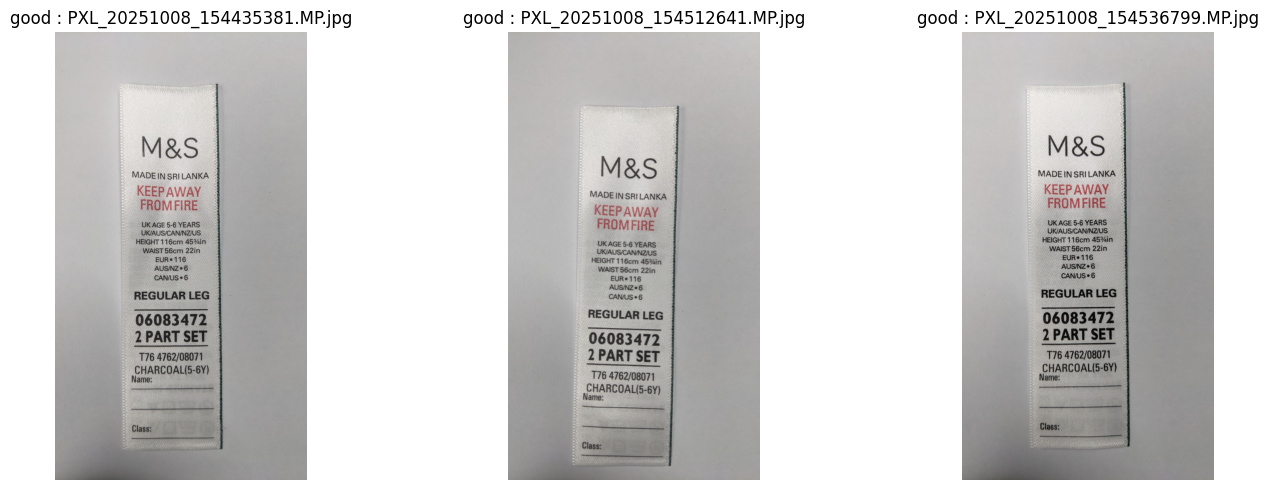

In [12]:
display_images('fabric_classification/train/good','good')


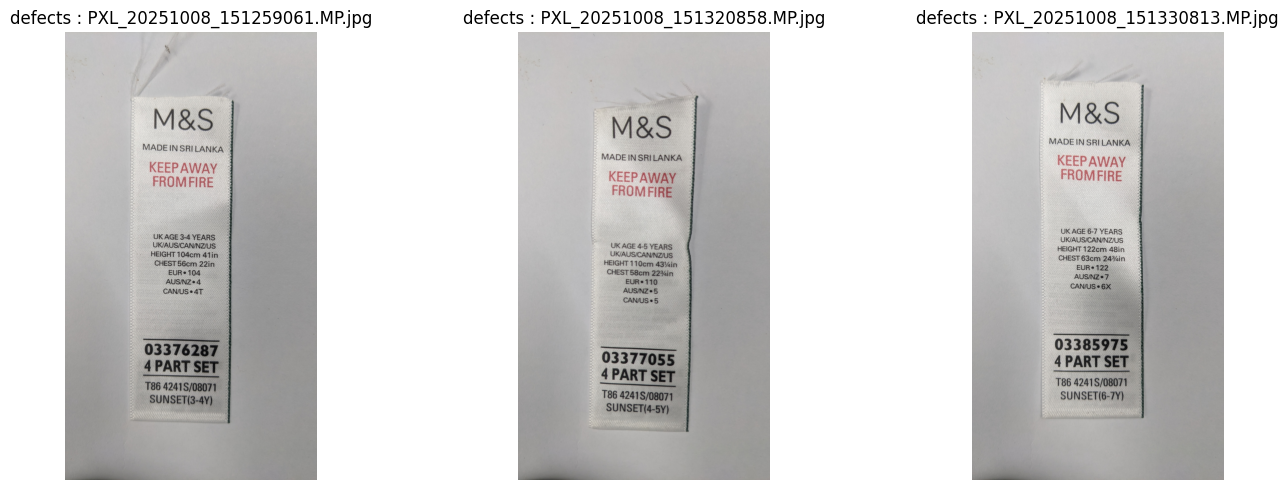

In [13]:
display_images('fabric_classification/train/defects','defects')

In [17]:
# Step 1 — collect all image paths
train_images = glob('fabric_classification/train/**/*.jpg', recursive=True)
val_images = glob('fabric_classification/val/**/*.jpg', recursive=True)

# Step 2 — get only file names (ignore folder structure)
#"fabric_classification/train/good/img_01.jpg" → "img_01.jpg" only get the name 

train_names = [os.path.basename(p) for p in train_images]
val_names = [os.path.basename(p) for p in val_images]

# Step 3 — find duplicates
duplicates = set(train_names) & set(val_names)

# Step 4 — print summary
print(f"Train images: {len(train_images)}")
print(f"Val images: {len(val_images)}")
print(f"Duplicates between train & val: {len(duplicates)}")

if len(duplicates) > 0:
    print("Warning: Data leakage detected!")
    print("Duplicate files:", list(duplicates)[:10])  # preview few duplicates

    # Step 5 — remove duplicates from val folder
    for img in duplicates:
        for cls in ['good', 'defect']:
            val_path = 'fabric_classification/val/{cls}/{img}'
            if os.path.exists(val_path):
                print(f"duplicate found val: {val_path}")

    print("Cleanup complete. Run this cell again to confirm no duplicates remain.")
else:
    print("No duplicates found. Splits look clean.")

Train images: 53
Val images: 7
Duplicates between train & val: 0
No duplicates found. Splits look clean.


In [19]:
results=model.train(
    data='fabric_classification',
    epochs=50,
    imgsz=224,
    patience=10,
    device=0 if torch.cuda.is_available() else 'cpu',
    workers=2,
    weight_decay=0.005,
    save=True,
    verbose=True,
)

Ultralytics 8.3.239  Python-3.10.19 torch-2.9.1+cpu CPU (12th Gen Intel Core i5-12450H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fabric_classification, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=

In [4]:
best_model=YOLO('runs/classify/train2/weights/best.pt')

In [5]:
df = pd.read_csv('runs/classify/train2/results.csv')

# Optional: check available columns
print(df.columns)

Index(['epoch', 'time', 'train/loss', 'metrics/accuracy_top1',
       'metrics/accuracy_top5', 'val/loss', 'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


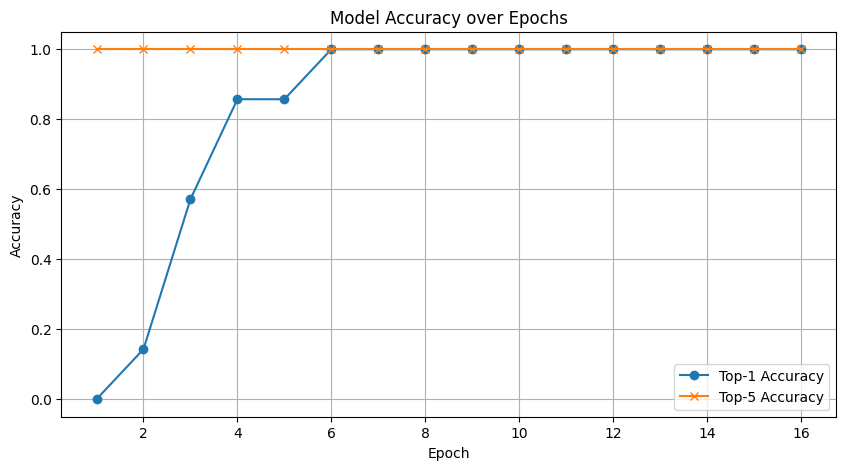

In [6]:
plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['metrics/accuracy_top1'], label='Top-1 Accuracy', marker='o')
plt.plot(df['epoch'], df['metrics/accuracy_top5'], label='Top-5 Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

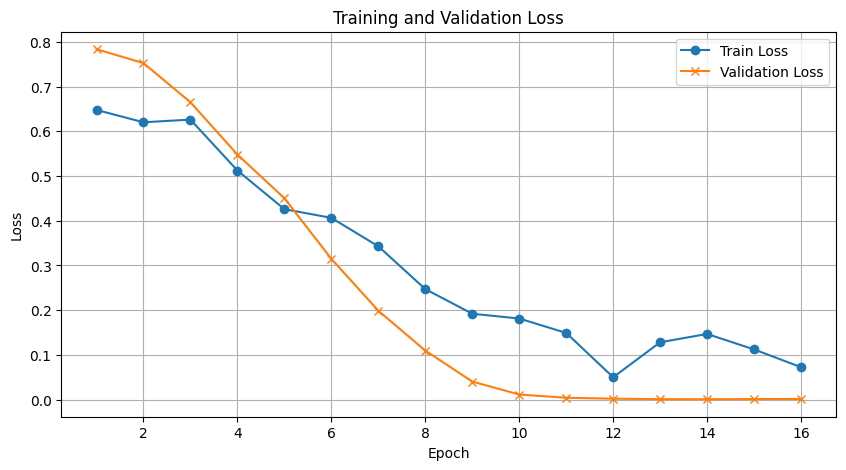

In [7]:
plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['train/loss'], label='Train Loss', marker='o')
plt.plot(df['epoch'], df['val/loss'], label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
metrics=best_model.val(
    data='fabric_classification',
    split='val'
)

Ultralytics 8.3.239  Python-3.10.19 torch-2.9.1+cpu CPU (12th Gen Intel Core i5-12450H)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\MSI\Documents\GitHub\ClothTagNet\fabric_classification\train... found 53 images in 2 classes  
val: C:\Users\MSI\Documents\GitHub\ClothTagNet\fabric_classification\val... found 7 images in 2 classes  
test: C:\Users\MSI\Documents\GitHub\ClothTagNet\fabric_classification\test... found 17 images in 2 classes  
val: Fast image access  (ping: 0.10.0 ms, read: 2267.6453.1 MB/s, size: 4032.8 KB)
val: Scanning C:\Users\MSI\Documents\GitHub\ClothTagNet\fabric_classification\val... 7 images, 0 corrupt: 100% ━━━━━━━━━━━━ 7/7  0.0s
val: C:\Users\MSI\Documents\GitHub\ClothTagNet\fabric_classification\val\defects\PXL_20251008_151310254.MP.jpg: corrupt JPEG restored and saved
val: C:\Users\MSI\Documents\GitHub\ClothTagNet\fabric_classification\val\defects\PXL_20251008_152015583.jpg: corrupt JPEG restored and save

In [9]:
print(f"Top-1 accuracy :{metrics.top1:.4f}")
print(f"Top-5 accuracy :{metrics.top5:.4f}")

Top-1 accuracy :1.0000
Top-5 accuracy :1.0000


In [11]:
base_dir="fabric_classification"


image 1/1 c:\Users\MSI\Documents\GitHub\ClothTagNet\fabric_classification\test\good\PXL_20251008_154502942.MP.jpg: 224x224 good 1.00, defects 0.00, 11.2ms
Speed: 39.6ms preprocess, 11.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
True classgood
Predicted:good confidence :1.00

image 1/1 c:\Users\MSI\Documents\GitHub\ClothTagNet\fabric_classification\test\good\PXL_20251008_154649701.jpg: 224x224 good 1.00, defects 0.00, 6.6ms
Speed: 48.0ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
True classgood
Predicted:good confidence :1.00

image 1/1 c:\Users\MSI\Documents\GitHub\ClothTagNet\fabric_classification\test\defects\PXL_20251008_151907341.MP.jpg: 224x224 defects 1.00, good 0.00, 9.1ms
Speed: 46.8ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
True classdefects
Predicted:defects confidence :1.00

image 1/1 c:\Users\MSI\Documents\GitHub\ClothTagNet\fabric_classification\test\defects\PXL_202

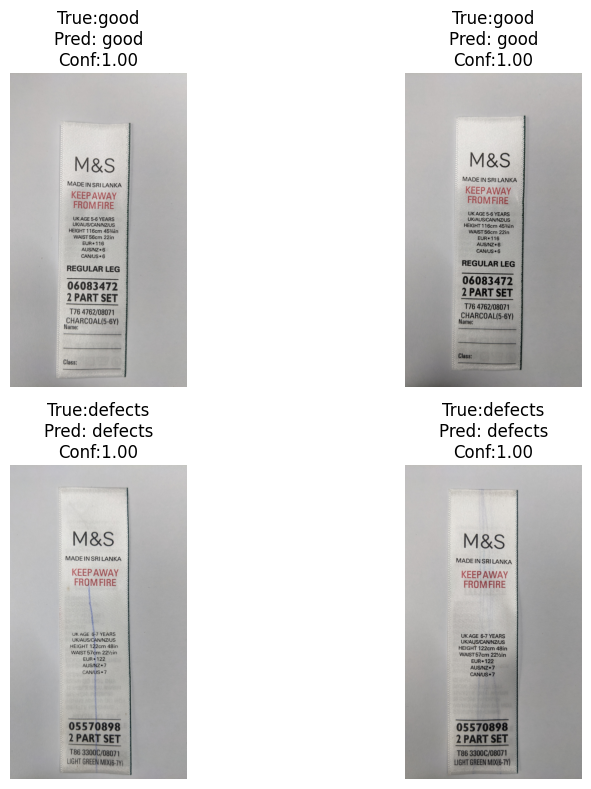

In [12]:
test_images=[]
test_good=os.listdir(f'{base_dir}/test/good')[:2]
test_defect=os.listdir(f'{base_dir}/test/defects')[:2]
for img in test_good:
  test_images.append(('good',f'{base_dir}/test/good/{img}'))
for img in test_defect:
  test_images.append(('defects',f'{base_dir}/test/defects/{img}'))

fig,axes=plt.subplots(2,2,figsize=(10,8))
axes=axes.ravel()

for idx, (true_class,img_path) in enumerate(test_images):
  results=best_model(img_path)
  probs=results[0].probs
  predicted_class=results[0].names[probs.top1]
  confidence=probs.top1conf.item()

  img=Image.open(img_path)
  axes[idx].imshow(img)
  axes[idx].set_title(f'True:{true_class}\nPred: {predicted_class}\nConf:{confidence:.2f}')
  axes[idx].axis('off')

  print(f'True class{true_class}')
  print(f'Predicted:{predicted_class} confidence :{confidence:.2f}')

plt.tight_layout()
plt.show()


image 1/1 C:\Users\MSI\Documents\GitHub\ClothTagNet\fabric_classification\test\defects\PXL_20251008_151907341.MP.jpg: 224x224 defects 1.00, good 0.00, 6.0ms
Speed: 44.3ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
defects
